In [26]:
# =========================
# Job Training (LaLonde) Analysis
# =========================

# 1) Imports 
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from scipy.stats import ttest_ind

from sklearn.neighbors import NearestNeighbors
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc

plt.style.use("ggplot")
sns.set_style("whitegrid")


In [28]:
# 2) Loading the data
lalonde_df = pd.read_csv("/Users/sadiatasnim/Downloads/lalonde.csv", index_col=0)
print(lalonde_df.head())
print(lalonde_df.columns)

   treat  age  educ  black  hispan  married  nodegree  re74  re75        re78
1      1   37    11      1       0        1         1   0.0   0.0   9930.0460
2      1   22     9      0       1        0         1   0.0   0.0   3595.8940
3      1   30    12      1       0        0         0   0.0   0.0  24909.4500
4      1   27    11      1       0        0         1   0.0   0.0   7506.1460
5      1   33     8      1       0        0         1   0.0   0.0    289.7899
Index(['treat', 'age', 'educ', 'black', 'hispan', 'married', 'nodegree',
       're74', 're75', 're78'],
      dtype='object')


In [30]:
# 3) Basic summary stats
summary_statistics = lalonde_df.describe()
print(summary_statistics)

# % whose earnings decreased from 1974 to 1975
decreased_income = (lalonde_df["re74"] > lalonde_df["re75"]).mean() * 100
print(f"% with re74 > re75: {decreased_income:.2f}%")

            treat         age        educ       black      hispan     married  \
count  614.000000  614.000000  614.000000  614.000000  614.000000  614.000000   
mean     0.301303   27.363192   10.268730    0.395765    0.117264    0.415309   
std      0.459198    9.881187    2.628325    0.489413    0.321997    0.493177   
min      0.000000   16.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000   20.000000    9.000000    0.000000    0.000000    0.000000   
50%      0.000000   25.000000   11.000000    0.000000    0.000000    0.000000   
75%      1.000000   32.000000   12.000000    1.000000    0.000000    1.000000   
max      1.000000   55.000000   18.000000    1.000000    1.000000    1.000000   

         nodegree          re74          re75          re78  
count  614.000000    614.000000    614.000000    614.000000  
mean     0.630293   4557.546569   2184.938207   6792.834483  
std      0.483119   6477.964479   3295.679043   7470.730792  
min      0.000000     

In [32]:
# 4) Treatment vs Control: earnings comparisons + t-test
treatment_percentage = lalonde_df["treat"].mean() * 100

mean_earnings_treatment = lalonde_df.loc[lalonde_df["treat"] == 1, "re78"].mean()
median_earnings_treatment = lalonde_df.loc[lalonde_df["treat"] == 1, "re78"].median()

mean_earnings_control = lalonde_df.loc[lalonde_df["treat"] == 0, "re78"].mean()
median_earnings_control = lalonde_df.loc[lalonde_df["treat"] == 0, "re78"].median()

earnings_treatment_group = lalonde_df.loc[lalonde_df["treat"] == 1, "re78"]
earnings_control_group = lalonde_df.loc[lalonde_df["treat"] == 0, "re78"]

t_stat, p_value = ttest_ind(earnings_treatment_group, earnings_control_group)

print(f"Percentage of workers in treatment group: {treatment_percentage:.2f}%")
print(f"Mean earnings (treatment): ${mean_earnings_treatment:.2f}")
print(f"Mean earnings (control):   ${mean_earnings_control:.2f}")
print(f"Median earnings (treatment): ${median_earnings_treatment:.2f}")
print(f"Median earnings (control):   ${median_earnings_control:.2f}")
print(f"Difference in mean earnings: ${mean_earnings_treatment - mean_earnings_control:.2f}")
print(f"Difference in median earnings: ${median_earnings_treatment - median_earnings_control:.2f}")

Percentage of workers in treatment group: 30.13%
Mean earnings (treatment): $6349.14
Mean earnings (control):   $6984.17
Median earnings (treatment): $4232.31
Median earnings (control):   $4975.51
Difference in mean earnings: $-635.03
Difference in median earnings: $-743.20


In [34]:
# 5) Descriptive stats by treat for key vars
continuous_vars = ["age", "educ"]
categorical_vars = ["black", "hispan", "married", "nodegree"]

print("\nDescriptive Statistics for Continuous Variables:")
for var in continuous_vars:
    print(f"\n{var.upper()}:")
    print(lalonde_df.groupby("treat")[var].describe())

print("\nFrequencies for Categorical Variables:")
for var in categorical_vars:
    print(f"\n{var.upper()}:")
    print(lalonde_df.groupby("treat")[var].value_counts(normalize=True))


Descriptive Statistics for Continuous Variables:

AGE:
       count       mean        std   min   25%   50%   75%   max
treat                                                           
0      429.0  28.030303  10.786653  16.0  19.0  25.0  35.0  55.0
1      185.0  25.816216   7.155019  17.0  20.0  25.0  29.0  48.0

EDUC:
       count       mean       std  min  25%   50%   75%   max
treat                                                        
0      429.0  10.235431  2.855238  0.0  9.0  11.0  12.0  18.0
1      185.0  10.345946  2.010650  4.0  9.0  11.0  12.0  16.0

Frequencies for Categorical Variables:

BLACK:
treat  black
0      0        0.797203
       1        0.202797
1      1        0.843243
       0        0.156757
Name: proportion, dtype: float64

HISPAN:
treat  hispan
0      0         0.857809
       1         0.142191
1      0         0.940541
       1         0.059459
Name: proportion, dtype: float64

MARRIED:
treat  married
0      1          0.512821
       0          0.487

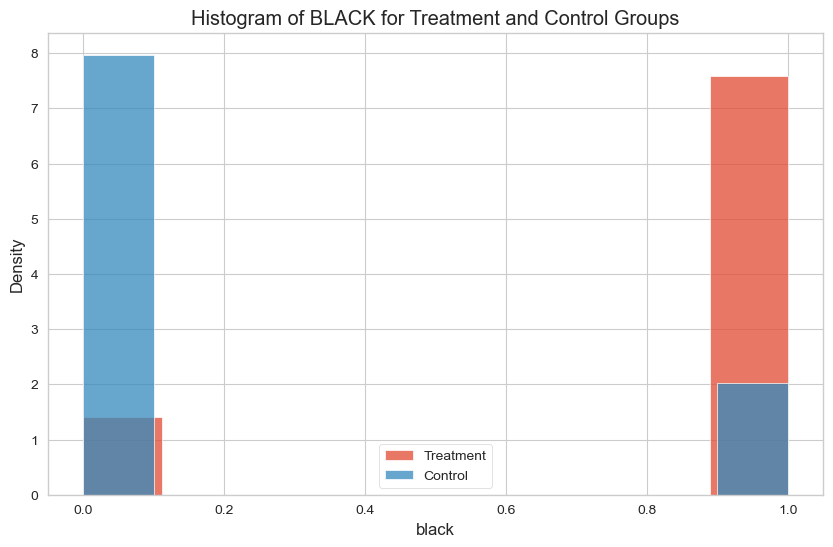

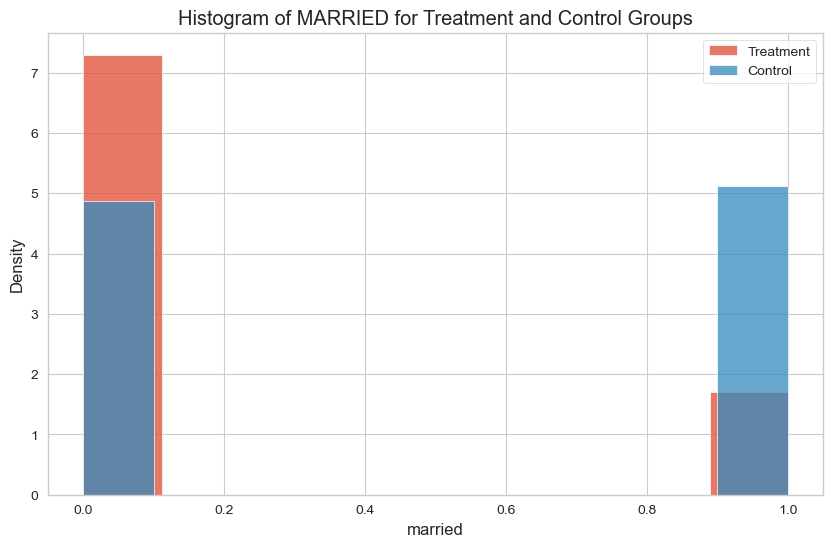

In [36]:
# 6) Covariate distribution plots (example: black, married)
treatment_group = lalonde_df[lalonde_df["treat"] == 1]
control_group = lalonde_df[lalonde_df["treat"] == 0]

plt.figure(figsize=(10, 6))
sns.histplot(treatment_group["black"], label="Treatment", kde=False, stat="density")
sns.histplot(control_group["black"], label="Control", kde=False, stat="density")
plt.title("Histogram of BLACK for Treatment and Control Groups")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(treatment_group["married"], label="Treatment", kde=False, stat="density")
sns.histplot(control_group["married"], label="Control", kde=False, stat="density")
plt.title("Histogram of MARRIED for Treatment and Control Groups")
plt.legend()
plt.show()

In [38]:
# 7) Propensity score model (Logit)
covariates = ["age", "educ", "black", "hispan", "married", "nodegree", "re74", "re75"]
X = lalonde_df[covariates]
y = lalonde_df["treat"]

logistic_model = sm.Logit(y, sm.add_constant(X)).fit()
lalonde_df["pscore_logit"] = logistic_model.predict(sm.add_constant(X))
print(logistic_model.summary())

Optimization terminated successfully.
         Current function value: 0.397267
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  treat   No. Observations:                  614
Model:                          Logit   Df Residuals:                      605
Method:                           MLE   Df Model:                            8
Date:                Mon, 16 Feb 2026   Pseudo R-squ.:                  0.3508
Time:                        22:02:23   Log-Likelihood:                -243.92
converged:                       True   LL-Null:                       -375.75
Covariance Type:            nonrobust   LLR p-value:                 2.194e-52
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.7286      1.017     -4.649      0.000      -6.722      -2.735
age            0.0158      0.

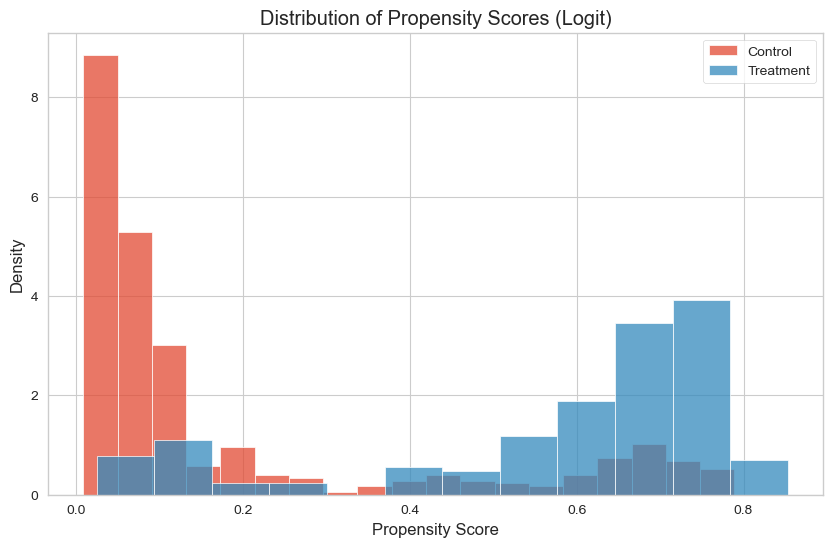

In [40]:
# 8) Plot propensity scores (before matching)
plt.figure(figsize=(10, 6))
sns.histplot(lalonde_df[lalonde_df["treat"] == 0]["pscore_logit"], label="Control", kde=False, stat="density")
sns.histplot(lalonde_df[lalonde_df["treat"] == 1]["pscore_logit"], label="Treatment", kde=False, stat="density")
plt.title("Distribution of Propensity Scores (Logit)")
plt.xlabel("Propensity Score")
plt.ylabel("Density")
plt.legend()
plt.show()

Matched shapes: (185, 11) (185, 11)


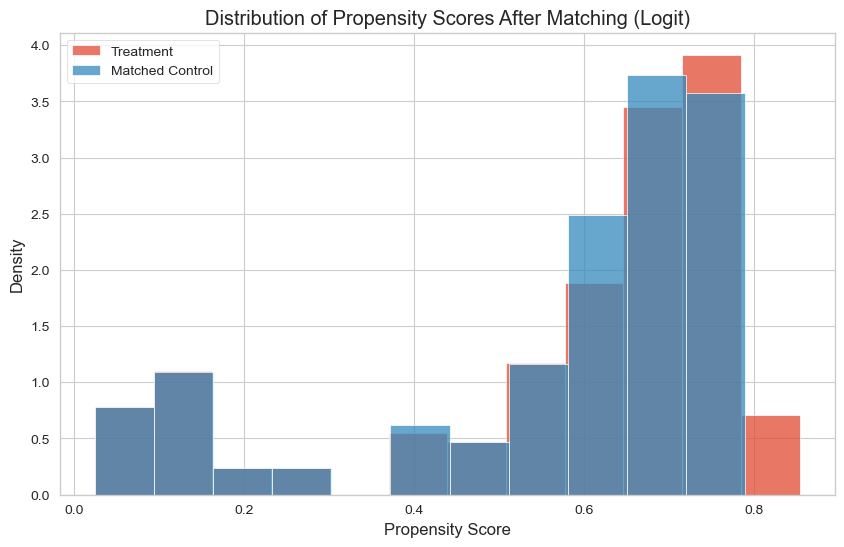

In [42]:
# 9) Nearest-neighbor matching on propensity score (Logit)
treat_pscores = lalonde_df[lalonde_df["treat"] == 1]["pscore_logit"].values.reshape(-1, 1)
control_pscores = lalonde_df[lalonde_df["treat"] == 0]["pscore_logit"].values.reshape(-1, 1)

knn = NearestNeighbors(n_neighbors=1, metric="euclidean")
knn.fit(control_pscores)
distances, indices = knn.kneighbors(treat_pscores)

treatment_df = lalonde_df[lalonde_df["treat"] == 1].copy()
matched_control_df = lalonde_df[lalonde_df["treat"] == 0].iloc[indices.flatten()].copy()

print("Matched shapes:", treatment_df.shape, matched_control_df.shape)

# Plot propensity scores after matching
plt.figure(figsize=(10, 6))
sns.histplot(treatment_df["pscore_logit"], label="Treatment", kde=False, stat="density")
sns.histplot(matched_control_df["pscore_logit"], label="Matched Control", kde=False, stat="density")
plt.title("Distribution of Propensity Scores After Matching (Logit)")
plt.xlabel("Propensity Score")
plt.ylabel("Density")
plt.legend()
plt.show()

In [44]:
# 10) Balance check: ASMD (Absolute Standardized Mean Differences)
means_treat_after = treatment_df[covariates].mean()
means_ctrl_after = matched_control_df[covariates].mean()

var_treat_before = lalonde_df[lalonde_df["treat"] == 1][covariates].var()
var_ctrl_before = lalonde_df[lalonde_df["treat"] == 0][covariates].var()

asmd = (means_treat_after - means_ctrl_after).abs() / np.sqrt((var_treat_before + var_ctrl_before) / 2)
print("\nASMD after matching (using pre-match variances):")
print(asmd.sort_values(ascending=False))


ASMD after matching (using pre-match variances):
age         0.187213
married     0.132189
re74        0.040728
hispan      0.018094
black       0.014076
educ        0.013134
nodegree    0.011408
re75        0.008639
dtype: float64



ATT (Logit propensity score matching): 1775.12


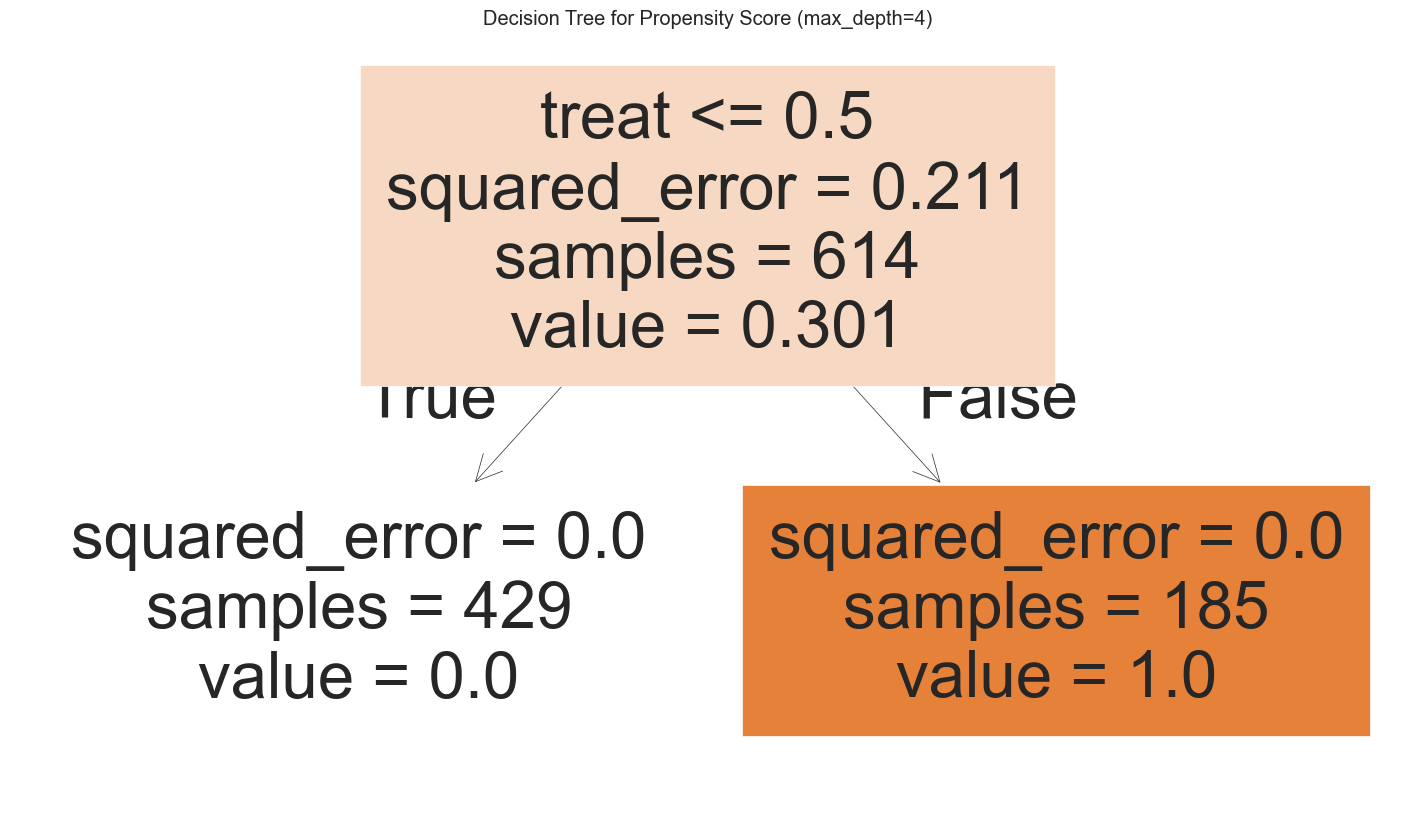

1    0.926088
2    0.803315
3    0.937627
4    0.959631
5    0.937717
Name: pscore_forest, dtype: float64


In [46]:
# 11) ATT after matching (Logit)
att_logit = treatment_df["re78"].mean() - matched_control_df["re78"].mean()
print(f"\nATT (Logit propensity score matching): {att_logit:.2f}")

# 12) Decision Tree propensity score (regressor used as in your PDF)
covariates_excluding_re78 = [c for c in lalonde_df.columns if c != "re78"]
X_tree = lalonde_df[covariates_excluding_re78]
y_tree = lalonde_df["treat"]
tree_regressor = DecisionTreeRegressor(max_depth=4, random_state=0)
tree_regressor.fit(X_tree, y_tree)
lalonde_df["pscore_tree"] = tree_regressor.predict(X_tree)

# Optional: visualize the tree
plt.figure(figsize=(18, 10))
plot_tree(tree_regressor, filled=True, feature_names=X_tree.columns)
plt.title("Decision Tree for Propensity Score (max_depth=4)")
plt.show()

# 13) Random Forest propensity score
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=0)
rf_classifier.fit(X_tree, y_tree)
lalonde_df["pscore_forest"] = rf_classifier.predict_proba(X_tree)[:, 1]
print(lalonde_df["pscore_forest"].head())

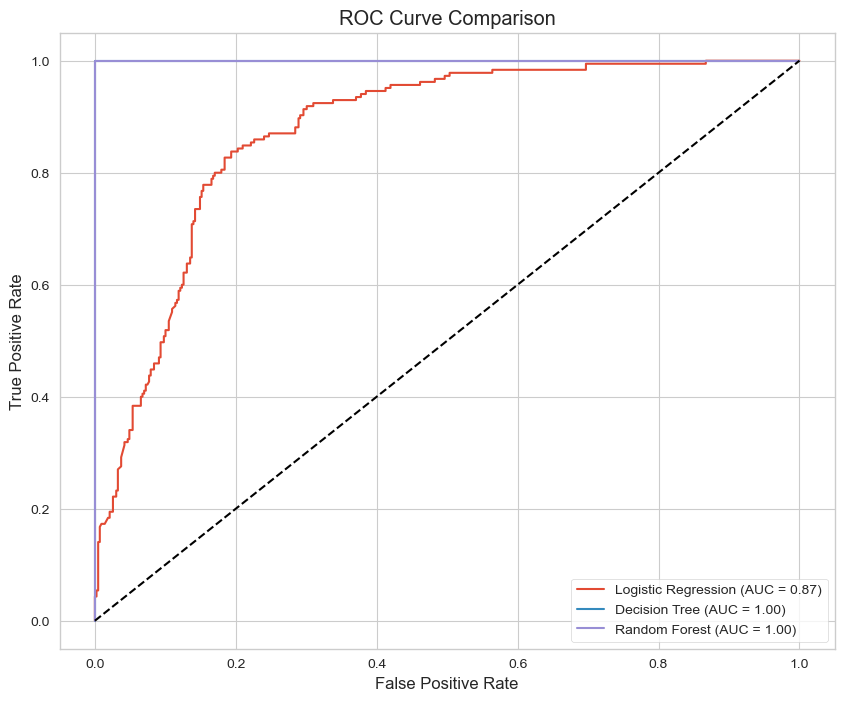

Logistic Regression AUC: 0.87
Decision Tree AUC: 1.00
Random Forest AUC: 1.00


In [48]:
# 14) ROC curves + AUC comparison
y_true = lalonde_df["treat"]

fpr_logit, tpr_logit, _ = roc_curve(y_true, lalonde_df["pscore_logit"])
roc_auc_logit = auc(fpr_logit, tpr_logit)

fpr_tree, tpr_tree, _ = roc_curve(y_true, lalonde_df["pscore_tree"])
roc_auc_tree = auc(fpr_tree, tpr_tree)

fpr_forest, tpr_forest, _ = roc_curve(y_true, lalonde_df["pscore_forest"])
roc_auc_forest = auc(fpr_forest, tpr_forest)

plt.figure(figsize=(10, 8))
plt.plot(fpr_logit, tpr_logit, label=f"Logistic Regression (AUC = {roc_auc_logit:.2f})")
plt.plot(fpr_tree, tpr_tree, label=f"Decision Tree (AUC = {roc_auc_tree:.2f})")
plt.plot(fpr_forest, tpr_forest, label=f"Random Forest (AUC = {roc_auc_forest:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.show()

print(f"Logistic Regression AUC: {roc_auc_logit:.2f}")
print(f"Decision Tree AUC: {roc_auc_tree:.2f}")
print(f"Random Forest AUC: {roc_auc_forest:.2f}")

In [50]:
# 15) Matching + ATT using tree and forest propensity scores
treatment = lalonde_df[lalonde_df["treat"] == 1].copy()
control = lalonde_df[lalonde_df["treat"] == 0].copy()

# Tree matching
knn_tree = NearestNeighbors(n_neighbors=1)
knn_tree.fit(control["pscore_tree"].values.reshape(-1, 1))
_, idx_tree = knn_tree.kneighbors(treatment["pscore_tree"].values.reshape(-1, 1))
matched_control_tree = control.iloc[idx_tree.flatten()]

att_tree = treatment["re78"].mean() - matched_control_tree["re78"].mean()
print(f"\nATT using decision tree propensity scores: {att_tree:.2f}")

# Forest matching
knn_forest = NearestNeighbors(n_neighbors=1)
knn_forest.fit(control["pscore_forest"].values.reshape(-1, 1))
_, idx_forest = knn_forest.kneighbors(treatment["pscore_forest"].values.reshape(-1, 1))
matched_control_forest = control.iloc[idx_forest.flatten()]

att_forest = treatment["re78"].mean() - matched_control_forest["re78"].mean()
print(f"ATT using random forest propensity scores: {att_forest:.2f}")


ATT using decision tree propensity scores: -19215.53
ATT using random forest propensity scores: -1194.65
